This Notebook reproduces results of the manuscript http://dx.doi.org/10.1016/j.neuroimage.2014.04.041. 
It also allows to inspect the data in more detail.

In [2]:
import sys
import os
import cPickle as pickle
from collections import defaultdict

from scipy.spatial.distance import pdist,squareform
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
%pylab inline

#the datamaker and ImageAnalysisComponents utilities reside two levels above this notebook.
utility_path = os.path.realpath(os.path.join(os.path.pardir, os.path.pardir))
sys.path.append(utility_path)
from regnmf import datamaker
from regnmf import ImageAnalysisComponents as ia
from regnmf.progress_bar import ProgressBar

Populating the interactive namespace from numpy and matplotlib


Define the location of the data. Data can be downloaded from zenodo.org at http://dx.doi.org/10.5281/zenodo.12352 .

In [3]:
datapath = 'please set the data path' #on my machine it's '../../../../Data'

For biological data it is generally difficult to asses factorization performance. 
To obtain nevertheless a detailed picture on the terms of performance for regularized NMF and sICA we constructed a parameterized surrogate dataset. 
With this dataset we could address two important questions: 
First, what is the influence of method inherent parameters and their optimal choice? 
And second, what is the application domain of both methods with respect to strength of pixel noise and size of measured stimuli set? 

In [4]:
load_paperdata = False # load the surrogate dataset that was used in the manuscript

In [5]:
param = {'act_time': [0.01, 0.1, 0.3, 0.8, 1.0, 1.0],
         'cov': 0.3,
         'latents': 40,
         'mean': 0.2,
         'no_samples': 50,
         'noisevar': 0.2,
         'shape': (50, 50),
         'width':0.1,
         'var': 0.08}

In [6]:
if load_paperdata :
    data = pickle.load(open(os.path.join(datapath,'surrogate','data.pik')))
else:
    data = datamaker.Dataset(param)
    os.mkdir(datapath)

OSError: [Errno 17] File exists: 'please set the data path'

In [7]:
# fontsizes
global_fs = 10
fs_num = 10

matplotlib.rcParams['axes.linewidth']=0.4
matplotlib.rcParams['axes.edgecolor']='k'

matplotlib.rcParams['xtick.major.size']=1     
matplotlib.rcParams['xtick.minor.size']=0.5      
matplotlib.rcParams['xtick.major.width']=0.3    
matplotlib.rcParams['xtick.minor.width']=0.3

matplotlib.rcParams['ytick.major.size']=1     
matplotlib.rcParams['ytick.minor.size']=0.5      
matplotlib.rcParams['ytick.major.width']=0.3    
matplotlib.rcParams['ytick.minor.width']=0.3  

matplotlib.rcParams['xtick.labelsize']=global_fs
matplotlib.rcParams['ytick.labelsize']=global_fs

matplotlib.rcParams['text.usetex']=False
matplotlib.rcParams['mathtext.default']='regular'

In [8]:
# parameter for visualizing sources
cmap_tmp = matplotlib.colors.LinearSegmentedColormap.from_list('tmp', ['w',np.array([147,112,219])/256.,'m','b'])
rgb_list = [cmap_tmp(i) for i in np.linspace(0,1,100)]+[plt.cm.jet(i) for i in np.linspace(0,1,101)]
cmap_bases = matplotlib.colors.LinearSegmentedColormap.from_list('bases', rgb_list)
param_imshow = {'cmap':cmap_bases, 'interpolation':'none', 'vmax':1, 'vmin':-1}

# axes layout for time courses
def mydecor(ax):
    ax.set_ylabel('activation', fontsize=global_fs, labelpad=-0.2)
    ax.yaxis.set_tick_params(labelsize=global_fs, labelright=True, labelleft=False)
    ax.yaxis.set_label_position('right')
    ax.xaxis.set_tick_params(labelsize=global_fs, pad=2)
    ax.set_xticks(range(60, 6*50, 60))
    
# timecourses plotter
splitnum = param['no_samples']
xparts = np.hsplit(np.arange(splitnum*len(param['act_time'])), splitnum)
def timeplot(ax, data):
    ax.plot(data, 'o', ms=1.5, mfc='k', mec='none')
    for x in xparts:
        ax.plot(x, data[x], '--',  dashes=(2,2), linewidth=0.4, color='k')
    #ax.set_ylabel('activation', fontsize=global_fs, labelpad=-0.2)
    ax.yaxis.set_tick_params(labelsize=global_fs, labelright=True, labelleft=False)
    ax.yaxis.set_label_position('right')
    ax.xaxis.set_tick_params(labelsize=global_fs, pad=2)
    ax.set_xticks(range(60, 6*50, 60))
    ax.set_yticks([0,1])

def no_ticks(ax):
    ax.set_xticks([])
    ax.set_yticks([])

def little_spines(ax):
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
def no_spines(ax):
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    no_ticks(ax)

To obtain useful conclusions, we've constructed sources resembling the main characteristics of the biological case: 
Glomeruli are arranged side by side with slightly overlapping spatial signal distribution (Fig. 1a)
The response spectra of surrogate glomeruli are narrowly tuned and correlated (Fig. 1b) and each glomeruli rises to peak activation with a model time-course (Fig. 1c). The data to enter factorization is the concurrent observation of forty glomeruli in response to $n_{stim}$ stimuli (e.g. odours) corrupted by additional pixel noise $\sigma_{\text{noise}}$. 

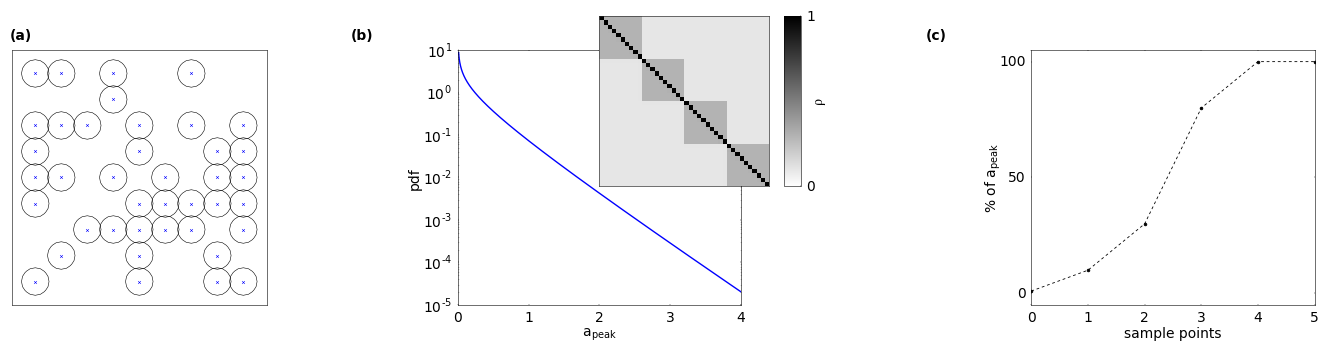

In [9]:
fig_dim = np.array((3.54, 1.1))*4
fig1 = plt.figure(figsize=fig_dim)
fig_ratio = fig_dim[0]/fig_dim[1]
panel_width = 0.18 
panel_bottom = 0.23

# ================================================================================
# Panel (a)
# ================================================================================
ax = fig1.add_axes([0.05, panel_bottom, panel_width, panel_width*fig_ratio])
ax.text(0.08, 1.03, '(a)', transform=ax.transAxes,
      fontsize=fs_num, fontweight='bold', va='bottom', ha='right')
# contours
for c in data.spt_sources:
    ax.contour(c.reshape((50,50))[::-1], [0.5] ,colors=['k'], label='0.3', linewidths=0.4)
# centers
p = ax.scatter(np.array(data.points)[:param['latents'],1], 49-np.array(data.points)[:param['latents'],0], 
           marker='x', s=4, label='max', linewidths=0.4)
ax.set_xlim([0.5,49.5])
ax.set_ylim([-0.5,48.5])
ax.set_xticks([])
ax.set_yticks([])

# =================================================================================
# Panel (b)
# =================================================================================
leftpos = 0.365
ax = fig1.add_axes([leftpos, panel_bottom,0.2, panel_width*fig_ratio])
ax.text(-0.3, 1.03, '(b)', transform=ax.transAxes,
      fontsize=fs_num, fontweight='bold', va='bottom', ha='right')
# plot marginal
ax.plot(np.arange(1E-2,4,0.001), datamaker.adjusted_gamma(param['mean'], param['var']).pdf(np.arange(1E-2,4,0.001)))
ax.set_yscale('log')
ax.set_xlabel('$a_{peak}$', fontsize=global_fs, labelpad=0.5)
ax.set_xticks([0,1,2,3,4])
ax.set_ylabel('pdf', fontsize=global_fs, labelpad=0.5)

# plot covariance
ax = fig1.add_axes([leftpos+0.1, 0.5, 0.12, 0.12*fig_ratio])
im = ax.imshow(data.cov, interpolation='none', vmin=0, vmax=1, cmap=plt.cm.binary)
ax.set_xticks([])
ax.set_yticks([])
axbar = fig1.add_axes([leftpos+0.11+0.12,0.5,0.012,0.12*fig_ratio])
# plot covariance colorscale
cbar = fig1.colorbar(im, axbar)
cbar.set_ticks([0,1])
cbar.set_label('$\\rho$', size=global_fs, labelpad=-0.5)

# ===================================================================================
# panel (c)
# ===================================================================================
ax = fig1.add_axes([0.77,panel_bottom,0.2,panel_width*fig_ratio])
ax.text(-0.3, 1.03, '(c)', transform=ax.transAxes,
      fontsize=fs_num, fontweight='bold', va='bottom', ha='right')

ax.plot(param['act_time'], 'o--', ms=2, mfc='k', linewidth=0.6, color='k', dashes=(2,2))
ax.set_xlabel('sample points', fontsize=global_fs, labelpad=1)
ax.set_ylim((-0.05, 1.05))
ax.set_ylabel('% of $a_{peak}$', fontsize=global_fs, labelpad=-3)
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,50,100])

plt.show()

__Fig. 1__ Surrogate data (a) 40 Gaussian shaped sources were randomly placed on a regular $9\times 9$ grid in a $50\times 50\text{px}$ image. Crosses mark centres of pixel participation and lines indicate half maximum (HM).
(b) The peak activations for each stimulus were drawn from a gamma distribution ($\mu=0.2$, $\sigma=0.28$). Inset shows covariance $\rho$ introduced via a Gaussian copula into the sources' activation.
(c) Each stimulus activation was extended to a 6 point model time-course.

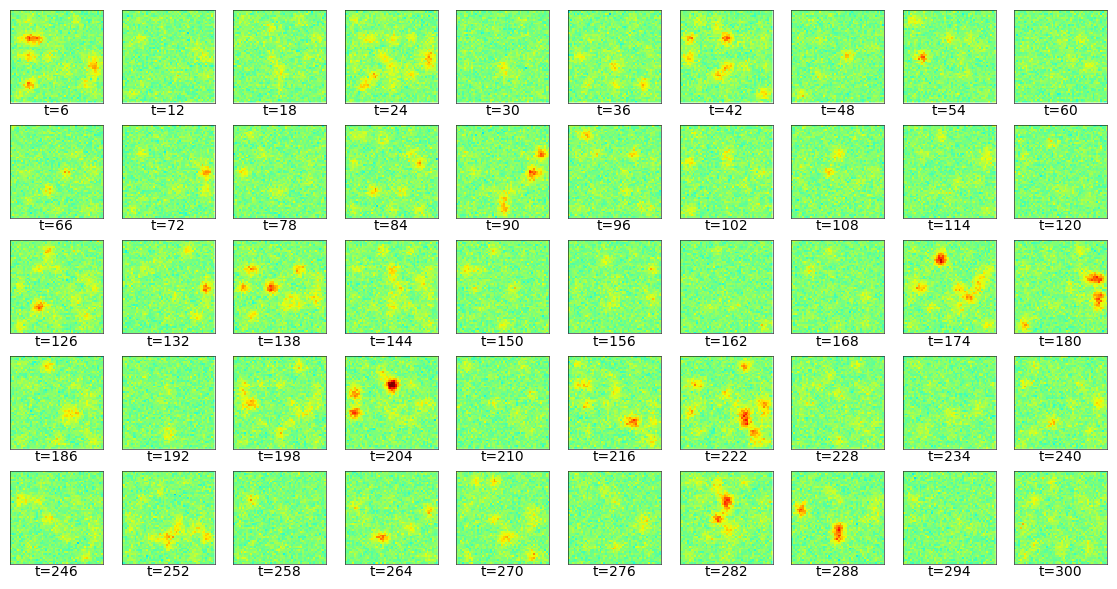

In [10]:
fig_dim = np.array((3.54, 1.8))*4
fig = plt.figure(figsize=fig_dim, dpi=200)
for i in range(50):
    ax = fig.add_subplot(5,10,i+1)
    ax.imshow(data.observed[(i+1)*len(param['act_time'])-1].reshape(param['shape']), interpolation='none', vmin=-2.5, vmax=2.5)
    ax.set_xlabel('t=%s'%((i+1)*6), size=global_fs, labelpad=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

__Fig. 2__ Observation of the combined signal at peak activation for different stimuli.
Signal is corrupted with pixel noise ($\sigma_{\text{noise}}=0.2$).

We started our analysis with a dataset roughly mimicking the properties of our IOS data with $n_{stim}=50$ stimulus observations and a noise level of $\sigma_{noise}=0.2$.
Figure 3 shows exemplary recovered sources from both regularized NMF ($\alpha_{sm}=2$,  $\alpha_{sp}=0.5$) and sICA, illustrating the general characteristics of the methods. 
Regularized NMF indeed showed the desired properties of a localized, sparse and smooth pixel participation, accurately reproducing the spatial and temporal characteristics of the source. 
In contrast plain sICA (with no additional processing applied) generates more holistic pixel participations, containing global noise contributions besides the local source contribution. 
This implies a more noisy reconstruction of the activation courses by sICA, especially for weaker signals.

In [11]:
# general NMF param
anal_param = {'sparse_param': 0.5,
              'factors': 80,
              'smooth_param': 2,
              'init':'convex', 
              'sparse_fct':'global_sparse',
              'verbose':0
              }

In [12]:
input_data = ia.TimeSeries(data.observed, shape=param['shape'])

from timeit import default_timer as timer

start = timer()
nmf_cuda = ia.NNMF_cuda(maxcount=50, num_components=anal_param['factors'], **anal_param)
nmf_cuda_out = nmf_cuda(input_data)
cudanmftime = timer() - start
print "Cuda NMF took {}s ".format(cudanmftime)

start = timer()
nmf = ia.NNMF(maxcount=50, num_components=anal_param['factors'], **anal_param)
nmf_out = nmf(input_data)
defaultnmftime = timer() - start

print "Original NMF took {}s ".format(defaultnmftime)

'''
sica = ia.sICA(num_components=anal_param['factors']) 
sica_out = sica(input_data)
'''

/home/sam/PycharmProjects/FUImagingCuda/regnmf/ImageAnalysisComponents.py:76: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if not(series == ''):


Cuda NMF took 0.451632022858s 
Original NMF took 27.3410558701s 


"\nsica = ia.sICA(num_components=anal_param['factors']) \nsica_out = sica(input_data)\n"

In [ ]:
nmf_match, nmf_cor, _ = data.cor2source(nmf_out)
nmf_cuda_match, nmf_cuda_cor, _ = data.cor2source(nmf_cuda_out)
# sica_match, sica_cor, _ = data.cor2source(sica_out)

In [ ]:
figsize = np.array((20,40))
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(40,3)
gs.update(left = 0.01, top = 0.96, bottom = 0.01)

for source_ind in range(40):

    gs_temp = matplotlib.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[source_ind,0], width_ratios=[1,4], wspace=0.01)
    ax = fig.add_subplot(gs_temp[0])
    im = ax.imshow(data.spt_sources[source_ind].reshape((50,50)), **param_imshow)
    ax.set_axis_off()
    
    ax = fig.add_subplot(gs_temp[1])
    timeplot(ax, data.activation[:,source_ind])

    
    gs_temp = matplotlib.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[source_ind,1], width_ratios=[1,4], wspace=0.01)
    ax = fig.add_subplot(gs_temp[0])
    im = ax.imshow(nmf_out.base.shaped2D()[nmf_match[source_ind]], **param_imshow)
    ax.set_axis_off()
    
    ax = fig.add_subplot(gs_temp[1])
    timeplot(ax, nmf_out._series[:,nmf_match[source_ind]])
    ax.text(10, ax.get_ylim()[1], r'$r^{tmp} = %.2f$'%nmf_cor[source_ind], size=7, va='top')
    
    gs_temp = matplotlib.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[source_ind,2], width_ratios=[1,4], wspace=0.01)
    ax = fig.add_subplot(gs_temp[0])
    im = ax.imshow(nmf_cuda_out.base.shaped2D()[nmf_cuda_match[source_ind]], **param_imshow)
    ax.set_axis_off()
    
    ax = fig.add_subplot(gs_temp[1])
    timeplot(ax, nmf_cuda_out._series[:,nmf_cuda_match[source_ind]])
    ax.text(10, ax.get_ylim()[1], r'$r^{tmp} = %.2f$'%nmf_cuda_cor[source_ind], size=7, va='top')
    
# colorbar
axbar = fig.add_axes([0.01, 0.992, 0.2, 0.003])
cbar = fig.colorbar(im, axbar, orientation='horizontal')
cbar.set_ticks([-1,0,1])
cbar.set_label('pixel participation', size=global_fs, labelpad=2)
cbar.ax.xaxis.set_tick_params(labelsize=global_fs, pad=2)

fig.text(0.15,0.97,'source')
fig.text(0.45,0.97,'NMF')
fig.text(0.75,0.97,'NMF_Cuda')
# fig.text(0.75,0.97,'sICA')

plt.show()

__Fig. 3__ Recovered sources in NMF and sICA. First column shows original sources, second column NMF and third column sICA reconstructions. NMF yields a localized source approximation, whereas the sICA component contains small pixel participations in the whole image. Furthermore some sICA components recover the source's activation course less well than the components in the NMF approach.

NMF factorisation clearly depends on the choice of parameters. 
To this end we evaluated their influence on factorization results and provide a heuristic for suitable parameter choice.

We first started with the parameter for smoothness regularisation, $\alpha_{\text{sm}}$.

This cell will take a bit longer to compute, so we're using a progress bar to shorten the wait ;)

In [ ]:
# do analysis for different smoothness settings
nmf_sm = {}
anal_param['sparse_param']=0.
parampoints = [{'smooth_param':i} for i in [0., 0.25, 0.5, 1, 2, 4, 8]]
pb = ProgressBar(len(parampoints))
pb.animate(0)
for npa,pa in enumerate(parampoints):
    anal_param.update(pa)
    # calculate  
    nmf = ia.NNMF(maxcount=50, num_components=anal_param['factors'])
    nmf.param.update(anal_param)
    nmf_out = nmf(ia.TimeSeries(data.observed, shape=param['shape']))
    nmf_sm['nmf_sm'+str(pa['smooth_param'])] = nmf_out
    pb.animate(npa+1)

In [ ]:
n_bases = 20 #number of bases to show
fig = plt.figure(figsize=(1*len(nmf_sm), 1*n_bases))
gs = gridspec.GridSpec(n_bases, len(nmf_sm))
gs.update(left=0.01, right=0.99, top=0.98, bottom=0.01)
for k_ix, k in enumerate(np.sort(nmf_sm.keys())):
    for base_ix, base in enumerate(nmf_sm[k].base.shaped2D()[:n_bases]):
        ax = fig.add_subplot(gs[base_ix, k_ix])
        im = ax.imshow(base, **param_imshow)
        ax.set_axis_off()
        if base_ix ==0:
            ax.set_title(k, size=10)
plt.show()

__Fig.4__ NMF components ($k=80$, $\alpha_{\text{sp}}=0$) influenced by increasing smoothness regularisation. Small scale structures were progressively disappearing.

Even with strong smoothness regularisation components contain contributions from different sources. Therefore we additionally introduce sparseness regularisation $\alpha_{\text{sp}}>0$, which regulates the number of components a pixel is participating. With regularisation too low a source is covered by multiple components. Under moderate regularisation, a component exactly describes a single source (Fig. 5) and a source is covered exactly by a single component. 
But setting $\alpha_{\text{sp}}$ too high results in disrupted components as any source overlap regions were prevented by the regularisation.

In [ ]:
# do example factorization for different sparseness settings
nmf_sp = {}
anal_param['smooth_param']=2.
sparseness = [{'sparse_param':0.125}, {'sparse_param':0.5}, {'sparse_param':2}, {'sparse_param':4}]
pb = ProgressBar(len(sparseness))
pb.animate(0)
for spi,sp in enumerate(sparseness):
    anal_param.update(sp)
    # calculate  
    nmf = ia.NNMF(maxcount=50, num_components=anal_param['factors'])
    nmf.param.update(anal_param)
    out = nmf(ia.TimeSeries(data.observed, shape=param['shape']))
    nmf_sp['nmf_sp'+str(sp['sparse_param'])] = out
    pb.animate(spi+1)

In [ ]:
n_bases = 10 #number of bases to show
figsize = np.array((1*len(nmf_sp), 1*n_bases))*2
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(n_bases+1, len(nmf_sp))
gs.update(left=0.03, right=0.99, top=1-0.4/(n_bases+1), bottom=0.02)
#show contours of all bases
for k_ix, k in enumerate(np.sort(nmf_sp.keys())):
    ax = fig.add_subplot(gs[0, k_ix], aspect='equal')
    for base_ix, base in enumerate(nmf_sp[k].base.shaped2D()):
        im = ax.contour(base[::-1], [0.5],  colors=['k'], alpha=0.5)
        ax.set_xticks([])
        ax.set_yticks([])
        if base_ix ==0:
            ax.set_title(k, size=10)
# show single bases
for k_ix, k in enumerate(np.sort(nmf_sp.keys())):
    for base_ix, base in enumerate(nmf_sp[k].base.shaped2D()[:n_bases]):
        ax = fig.add_subplot(gs[base_ix+1, k_ix])
        im = ax.imshow(base, **param_imshow)
        ax.set_axis_off()
plt.show()

__Fig. 5__ NMF components with increasing sparseness regularisation. First row shows half maximum contours of all components. Further rows show pixel participation of single components. With regularisation too low a source is covered by multiple components. Strongly regularized components cover only part of the source.

To further quantify the effect of sparseness regularization we employ two measures. First, we exploit our knowledge on the actual sources and calculate their recovery $SR_{k}$ by the components. 
Second, we measure shared explanation of pixel groups in multiple components via spatial correlation between components $r_{k}^{\text{comp}}$. 
This is an uninformed measure not depending on any knowledge of actual sources, and hence is also applicable when the ground truth is not known, i.e. in real experimental data.
It shows, that the range of maximal source recovery is in a regime where all strong component correlations became eliminated but some residual correlation is left.

In [ ]:
num_testsets = 5
datasets = [datamaker.Dataset(param) for dummy in range(num_testsets)]

The next cell takes rather long to compute. Depending on your hardware, it will easily take 20 minutes or more. 

In [ ]:
#This takes quite a long time (>20 min, depending on your hardware).
#Consider loading the cached results below.

sp_param = [0]+ [2**i for i in np.arange(-7,3)]
sp_cors, st_cors, max_basecor, mse, mse_local = [defaultdict(list) for i in range(5)]

pb = ProgressBar(len(datasets)*len(sp_param))
pb.animate(0)

for dsi,dataset in enumerate(datasets):
    
    #do NMF with different sparseness
    for spi,sp in enumerate(sp_param):
        key = 'nmf_'+str(sp)        
        anal_param.update({'sparse_param':sp})
        factors = anal_param['factors']
        # calculate  
        nmf = ia.NNMF(maxcount=50, num_components=factors)
        nmf.param.update(anal_param)
        nmf_out = nmf(ia.TimeSeries(dataset.observed, shape=param['shape']))       
       
        #performance criteria
        _, st_cor, sp_cor = dataset.cor2source(nmf_out)
        sp_cors[key].append(sp_cor)
        st_cors[key].append(st_cor)
        max_basecor[key].append(np.nanmax(np.corrcoef(nmf_out.base._series) - np.diag(np.ones(factors)),0))      
        mse[key].append(dataset.mse2source(nmf_out))
        mse_local[key].append(dataset.mse2source(nmf_out, local=0.05))
        pb.animate(dsi*len(sp_param) + spi +1)

Use the two cells below if you want to save/load this data, so you won't have to recalculate it next time. 

In [ ]:
# This is used to save the generated results.
#import cPickle
#cached_data = (datasets, sp_param, sp_cors, st_cors, max_basecor, mse, mse_local)
#cPickle.dump(cached_data, open('cached_data_for_spatial_component_corr.pik','w'))

In [ ]:
# This is to load cached data instead
#import cPickle
#datasets, sp_param, sp_cors, st_cors, max_basecor, mse, mse_local = cPickle.load(open('cached_data_for_spatial_component_corr.pik'))

In [ ]:
figsize = np.array((2,2))*3
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0.15,0.25,0.8,0.7])


mykeyorder = np.sort(['nmf_'+str(sp) for sp in sp_param])
x = np.arange(len(mykeyorder))

mean_SR = [[1-np.mean(i) for i in mse[k]] for k in mykeyorder]
ax.plot(x, [np.mean(i) for i in mean_SR], ':og',  mec='none', ms=3,  linewidth=0.5, dashes=(2,2), label='mean $SR_k$')
ax.errorbar(x, [np.mean(i) for i in mean_SR], yerr = [np.std(i) for i in mean_SR],  fmt="none", linewidht=0.5,
             ecolor='g', elinewidth=0.5, capsize=1)


basecor = [[np.max(i) for i in max_basecor[k]] for k in mykeyorder]
ax.plot(x, [np.mean(i) for i in basecor], ':sb', mec='none', ms=3, linewidth=0.5, dashes=(2,2), label='max $r^{comp}_k$')
ax.errorbar(x, [np.mean(i) for i in basecor], yerr = [np.std(i) for i in basecor], 
            fmt="none", linewidht=0.5, ecolor='b', elinewidth=0.5, capsize=1)


# Axes Decoration
ax.set_xticks(x)
ax.set_xticklabels(['0']+['$2^{%d}$'%i for i in np.log2(sp_param[1:])], size=global_fs, rotation='45') 
ax.set_xlim([-0.5, len(mykeyorder)-0.5])
ax.set_yticks([0, 0.5, 1])
ax.set_ylim([0,1.05])
ax.set_yticklabels(['0', '.5', '1'], size=global_fs) 
ax.yaxis.set_tick_params(labelsize=global_fs, pad=2)
little_spines(ax)
ax.set_xlabel('$\\alpha_{sp}$', labelpad=2, size=global_fs)
ax.legend(prop={'size':global_fs}, numpoints=1, loc = 'upper left', labelspacing=0.1, handletextpad=0.2, 
          bbox_to_anchor = (0.65, 0.95), borderaxespad=0, frameon=False)
plt.show()

__Fig. 6__ Maximal spatial component correlation $r^{comp}$ and it's standard deviation over dataset instances (blue) respectively mean recovery $SR_k$ (green) in dependence of $\alpha_{\text{sp}}$ ($k=80$, $\alpha_{\text{sm}}=2$).
Source recovery becomes maximal in the regime where maximal component correlation is strongly decreasing.   

To become a better understanding of the measure source recorvery SR, we also take a look at temporal and spatial correlation of source to components.
It shows that exspecially temporal accuracy is very high, even for components with moderate source recovery values and hence some spatial inaccuracy. 

In [ ]:
figsize = np.array((2,2))*2
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(2,2, width_ratios=[2,1], height_ratios=[1,2], hspace=0.02, wspace=0.02)
gs.update(left=0.2, right=0.95, top=0.95, bottom=0.2)

toplot = 'nmf_0.5'

x = st_cors[toplot]
y = np.nanmax(sp_cors[toplot],1)

axlim = np.floor(10*np.min(np.array([x,y])))/10. #set lower limit of axes

#marginal distribution of x
ax = fig.add_subplot(gs[0,0])
ax.hist(np.hstack(x), bins = np.arange(axlim,1.001,0.1), edgecolor='none', histtype='stepfilled')
ax.set_xlim((axlim,1))
ax.set_ylim((0,len(np.hstack(x))))
no_spines(ax)

#marginal distribution of y
ax = fig.add_subplot(gs[1,1])
ax.hist(np.hstack(y), bins = np.arange(axlim,1.001,0.1), edgecolor='none', histtype='stepfilled', orientation='horizontal')
ax.set_xlim((0,len(np.hstack(y))))
ax.set_ylim((axlim,1))
no_spines(ax)

#scatter plot x vs y
ax = fig.add_subplot(gs[1,0])
mse_color = [plt.cm.RdYlGn(i/0.8) for i in (1-np.hstack(mse[toplot]))]
ax.scatter(x, y, marker='o', linewidths=0.4, s=10, facecolors= mse_color, edgecolors=mse_color)

# decorate axes
ax.plot([axlim, 1], [axlim,1], 'k:', lw=0.5)
ax.set_ylim((axlim,1))
ax.set_xlim((axlim,1))
ax.set_xticks((axlim,1))
ax.set_xticks(np.arange(axlim,1,0.05), minor=True)
ax.set_yticks((axlim,1))
ax.set_yticks(np.arange(axlim,1,0.05), minor=True)
ax.set_ylabel(r'$r^{spt}$', fontsize=global_fs+2, labelpad=-4)
ax.set_xlabel(r'$r^{tmp}$', fontsize=global_fs+2, labelpad=-4)

#labeling of histograms
ax = fig.add_subplot(gs[0,1])
ax.set_xlim((0,100))
ax.set_ylim((0,100))
ax.set_yticks([100])
ax.set_xticks([100])
little_spines(ax)
ax.xaxis.set_tick_params(direction='inout')
ax.yaxis.set_tick_params(direction='inout')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(1, 100, '100%', fontsize=global_fs, va='center')
ax.text(100, 5, '100%', fontsize=global_fs, rotation='270', va='bottom', ha='center')
plt.show()

__Fig. 7__ Spatial and temporal correlation of matched components ($k=80$, $\alpha_{\text{sm}}=2$, $\alpha_{\text{sp}}=0.5$) to 200 sources of five dataset instances. The color of each dot indicates the corresponding SR value. Histograms depict marginal distribution for both axes.
Especially temporal reconstruction was very precise for almost all sources whereas lower SR values stemmed from inaccurate spatial reconstruction.

To benchmark regularized NMF we performed sICA on the same dataset instances. 
In sICA both spatial and temporal reconstruction of sources were more noisy (see Fig. 3). 
The many but small non-local values for pixel participation lower the previously used measure of source recovery for sICA to less accurate values than actually could be achieved by simple post-processing like thresholding. 
To account for such post-processing and enable a fair comparison we only computed source recovery for localized sICA components ($\text{sICA}^{\text{loc}}$).
Nonetheless $\text{sICA}^{\text{loc}}$ components showed significantly lower source recovery than NMF components (Fig. 7a).
The advantage of NMF especially stood out in the temporal reconstruction of sources (Fig. 7b).
Whereas lower source recovery values in NMF still implied a precise temporal source reconstruction, this was not the case for sICA. 

In [ ]:
for dataset in datasets:

    factors = anal_param['factors']
    key = 'sica_%d'%factors
    # calculate  
    sica = ia.sICA(num_components=factors) 
    sica_out = sica(ia.TimeSeries(dataset.observed, shape=param['shape']))    
       
    #performance criteria
    _, st_cor, sp_cor = dataset.cor2source(sica_out)
    sp_cors[key].append(sp_cor)
    st_cors[key].append(st_cor)
    max_basecor[key].append(np.nanmax(np.corrcoef(sica_out.base._series) - np.diag(np.ones(factors)),0))      
    mse[key].append(dataset.mse2source(sica_out))
    mse_local[key].append(dataset.mse2source(sica_out, local=0.05))

In [ ]:
figsize= np.array((3,1.5))*3
fig = plt.figure(figsize=figsize)

gs = gridspec.GridSpec(1,2)
gs.update(left=0.1, right=0.95, top=0.85, bottom=0.2, wspace=0.5)        

#plot SR distributions for 'toplot' and sica_80
ax = fig.add_subplot(gs[0])
ax.text(-0.06, 1.05, '(a)', transform=ax.transAxes,
      fontsize=fs_num, fontweight='bold', va='bottom', ha='right')
ax.hist(1-np.hstack(mse[toplot]), np.linspace(0,1,21), edgecolor='none', facecolor='0.7', label='NMF')
ax.hist(1-np.hstack(mse_local['sica_80']), np.linspace(0,1,21), histtype='step', color='k', label='$sICA^{loc}}$')

# Decorate
ax.set_ylabel('#', fontsize=global_fs, labelpad=0)
ax.set_xlabel('$SR_k$', fontsize=global_fs, labelpad=2)
little_spines(ax)
ax.yaxis.set_tick_params(pad=2, labelsize=global_fs)
ax.xaxis.set_tick_params(pad=2, labelsize=global_fs)
ax.set_xticks([0,0.4,0.8])
ax.legend(prop={'size':global_fs}, numpoints=1, loc = 'upper left', labelspacing=-0.2, handletextpad=0.2, 
                bbox_to_anchor = (0.025, 1.04), borderaxespad=0, frameon=False)
 
#plot temporal reconstruction for 'toplot' and sica_80
ax = fig.add_subplot(gs[1])
ax.text(-0.1, 1.05, '(b)', transform=ax.transAxes,
      fontsize=fs_num, fontweight='bold', va='bottom', ha='right')
ax.plot(np.hstack(st_cors['sica_80']), np.hstack(st_cors[toplot]), '.k', ms=5, mfc='none')
ax.plot([0,1],[0,1], ':', color='0.5', lw=0.4)

# Decorate
ax.set_ylabel('$r^{tmp}_{NMF}$', fontsize=global_fs, labelpad=-5)
ax.set_xlabel('$r^{tmp}_{sICA}$', fontsize=global_fs, labelpad=-5)
little_spines(ax)
ax.yaxis.set_tick_params(pad=2)
ax.yaxis.set_tick_params(pad=2, labelsize=global_fs)
ax.set_yticks([0,1])
ax.set_yticks([0.25,0.5,0.75], minor=True)
ax.xaxis.set_tick_params(pad=2, labelsize=global_fs)
ax.set_xticks([0,1])
ax.set_yticks([0.25,0.5,0.75], minor=True)

plt.show()

__Fig. 7__
(a) Distribution of source recovery $SR_k$ for NMF (solid grey, $k=80$, $\alpha_{\text{sm}}=2$, $\alpha_{\text{sp}}=0.5$) and localized sICA components $\text{sICA}^{\text{loc}}$ (black line, $k=80$) in five instances of the surrogate dataset.
(b) Temporal correlation $r^{\text{tmp}}$ of actual sources to NMF and sICA components. NMF components exhibited a more precise temporal reconstruction of sources..

The surrogate data provided insight into application domain of the methods and yielded a heuristic for parameter choice. 
But the *in-vivo* IOS data is a lot more complex. With respect to spatial characteristics, glomeruli have varying size and shapes and also the exact spatial signal distribution is unknown. 
Furthermore the temporal characteristics of glomeruli do not obey an unique probability distribution but vary strongly in overall peak activation strength and odour selectivity. 

In [ ]:
prepro_param = {'baseline_cut':(0,10),
                'temporal_binning':12,
                'low_pass':1,
                'high_pass':10,
                'spatial_subsamp':2}
more_param = {'odor_response':(2,5), #range of frames which are averaged to yield odor response}
              'snapshot': (3,4)} #frames to plot as odor images

OMP-SpH-mice were anaesthetized using urethane. All animal care and procedures were in accordance with the animal ethics guidelines of the Max Planck Society.
 
Odour molecules reached the nose $2.5\pm0.3\text{s}$ after recording onset as measured by a Photoionization detector.
In each animal the response to a stimulus set of 48 to 49 odours was recorded. 
Each odour stimulus was repeated at least twice and stimuli were represented in a pseudo-randomized sequence.

To increase signal-to-noise ratio and reduce computational load the raw data was preprocessed. 
First we applied an $8\times8\text{px}$ spatial and a $12$ frame temporal binning ('raw' data available in this notebook already was spatially binned $4\times4\text{px}$ to save storage). 
Then the odour induced activation was calculated as the relative decrease of reflectance $-\Delta R / R = -(R-R_0)/R$. 
$R_0$ is the mean reflectance until $2s$ after recording onset. 
Furthermore the data was spatially bandpass filtered with two Gaussian filters ($\sigma_{\text{low}}=10\text{px}$, $\sigma_{\text{high}}=1\text{px}$) and down-sampled by a factor of 2. 

In [ ]:
measids = ['111210sph','111222sph','111221sph']
ios_data = defaultdict(dict)

for measid in measids:
    
    filename = os.path.join(datapath,measid,'timeseries')
    ts = ia.TimeSeries()
    ts.load(filename)
    
    #preprocess:
    #relative change
    baseline = ia.TrialMean()(ia.CutOut(prepro_param['baseline_cut'])(ts))
    ts = ia.RelativeChange()(ia.TrialMean(ts.num_timepoints/prepro_param['temporal_binning'])(ts), baseline)
    #bandpass
    lowpassed = ia.Filter('gauss', prepro_param['low_pass'], downscale=prepro_param['spatial_subsamp'])(ts)
    highpassed = ia.Filter('gauss', prepro_param['high_pass'], downscale=prepro_param['spatial_subsamp'])(ts)
    ts = ia.Combine(np.subtract)(lowpassed, highpassed)
    # scale to positive activation and to promille values
    ts._series *= -1000
    
    ios_data[measid]['ts'] = ts
    ios_data[measid]['bg'] = plt.imread(os.path.join(datapath, measid, 'green.png'))
    ios_data[measid]['gloms'] = pickle.load(open(os.path.join(datapath, 'anatomical_outlines.pik')))[measid]

In [ ]:
# plot image maps
toplot = '111210sph'
image_maps = ia.TrialMean()(ia.CutOut(more_param['snapshot'])(ios_data[toplot]['ts']))
odournames = pickle.load(open(os.path.join(datapath,'odournames.pik')))

dim2 = int(np.ceil(image_maps.num_stimuli/10.))
fig_dim = np.array((10, 1*dim2*0.75))*1.8
fig = plt.figure(figsize=fig_dim)

old_name = 'name'
for ix, i_map in enumerate(image_maps.shaped2D()):
    ax = fig.add_subplot(dim2, 10,  ix+1)
    im_h = ax.imshow(i_map, interpolation='none', vmin=-np.max(i_map))
    ax.set_ylabel('max: %.1f'%np.max(i_map), size=global_fs, labelpad=0)
    odour = odournames[image_maps.label_stimuli[ix]]
    if old_name != odour:
        ax.set_title(odour, size=9, y=0.95, ha='left')
    old_name = odour
    no_ticks(ax)

axbar = fig.add_axes([0.05,0.85,0.01,0.1])       
cbar = fig.colorbar(im_h, axbar)
cbar.set_ticks([0,np.max(i_map)])
cbar.set_ticklabels([0,'max'])

plt.show()

__Fig. 8__ Examples of odour response maps: Mean $-\Delta R/R$ 6s after odour delivery. Images are scaled to maximal pixel activation (indicated on the left of each image). 

As we don't know the ground truth in the biological case, we additionaly performed 2-photon synapto-pHluorin imaging of the resting fluorescence to obtain anatomical glomeruli outlines. We then manually outlined glomeruli in the Z-stacks
The outlines did not provide full information on the actual pixel participation of glomeruli but rather binary information on glomerular position. 
Furthermore the exact position was possibly impaired by the manual outlining process and the alignment of functional and anatomical pictures. 
This made it difficult to derive objective quality criteria but allowed for visual inspection of match between outlined glomeruli and extracted components.

In [ ]:
figsize = np.array((3,2))*3
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

ax.imshow(ios_data[toplot]['bg'], interpolation='none', cmap=plt.cm.bone, vmin=-1, vmax=1, extent=[0, 83, 0, 63])
no_ticks(ax)
ax.hold(True)
for r in ios_data[toplot]['gloms']:
    ax.contour(r, [0.3], extent=[0, 83, 63, 0], colors=['y'], linewidths=2)
plt.show()

__Fig 9__ Glomeruli outlines (yellow) aligned to green image of the dorsal OB.

So, did our general observations on the surrogate dataset still held for the IOS data?   
To answer this, we performed sICA and NMF for three exemplary measurements according to our deduced heuristic. 
We chose $k=150$, well above the approximately activated sixty glomeruli. 
Additionally in NMF we set $\alpha_{\text{sm}}=2$ to avoid one-pixel scale structures and $\alpha_{\text{sp}}=0.5$, necessary for removing any component correlation above 0.5. 

In [ ]:
nmf_param = {'config_name': 'nmf150_sp05_sm2',
             'num_components':150,
             'sparse_param':0.5,
             'smooth_param':2.,
             'init':'convex',
             'maxcount':50,
             'verbose':10}
sica_param = {'config_name':'sica150',
              'num_components':150}

The following cell is another long-runner (> 15min). 

In [ ]:
# apply factorizations
# this is another long running calculation. Consider loading cached data if you're in a hurry.

for measid in measids:
    for factorizer, param in [(ia.NNMF, nmf_param), (ia.sICA, sica_param)]:
        print("measurement {}, {}".format(measid, factorizer))
        f = factorizer(**param)( ios_data[measid]['ts'])
        f.base._series[np.isnan(f.base._series)] = 0
    
        results={}
        results['factorization'] = f 
        results['spec'] = ia.TrialMean()(ia.CutOut(more_param['odor_response'])(f))
        results['odor_response'] = ia.SingleSampleResponse()(results['spec'])
        results['t2t_cor'] = ia.CalcStimulusDrive()(results['spec'])
    
        ios_data[measid][param['config_name']] = results

Use the two cells below to save/load the results for later.

In [ ]:
#caching data
#cPickle.dump(ios_data, open('cached_ios_decomp.pik','w'))

In [ ]:
#loading cached results
#ios_data = cPickle.load(open('cached_ios_decomp.pik', 'r'))

In [ ]:
# helper function to plot timecourses
rep_param = defaultdict(lambda: {'linewidth':1, 'ls':'--', 'color':'0.8'})
rep_param.update({0:{'linewidth':0.6, 'ls':'--' , 'color':'b','marker':'.', 'ms':2, 'dashes':(2,2)}, 
                  1:{'linewidth':0.6, 'ls':'--', 'color':'g', 'marker':'.','ms':2, 'dashes':(2,2), 'mec':'0.4'}})

def timeplot(ax, data, mode):
    xtime = np.arange(data.num_timepoints)
    stimpos_dict = defaultdict(list)
    for lab_ind, lab in enumerate(data.label_stimuli):
        stimpos_dict[lab].append(lab_ind)
    for stim_num, stim in enumerate(stimpos_dict.keys()):
        for stimrep, stimpos in enumerate(stimpos_dict[stim]):
            xpoints = xtime + stim_num*data.num_timepoints                 
            if stim_num == 0: # plot with legend
                ax.plot(xpoints, data.trial_shaped()[stimpos,:,mode], label='trial %d'%(stimrep+1), **rep_param[stimrep])
            else:
                ax.plot(xpoints, data.trial_shaped()[stimpos,:,mode],**rep_param[stimrep])

    myxticks = np.hstack([xtime+i*data.num_timepoints for i in range(len(stimpos_dict))])
    yticks = [0,1,2]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)
    ax.yaxis.set_tick_params(labelsize=7)
    ax.set_xticks(range(0, len(stimpos_dict)*5, 5))
    ax.set_xticklabels([])
    ax.set_xlim((0,len(stimpos_dict)*5))
    ax.yaxis.set_ticks_position('right')

In both NMF and sICA some of the extracted components resembled in their characteristics glomeruli, both in the spatial extent and the activation course. But other rather look like parts of blood vessels or noise.
To distinguish putative glomeruli components from the rest we exploited the trial-to-trial correlations $r_k^{\text{t2t}}$ of the components odour spectra. 

In [ ]:
fig_dim = np.array((10, 20))*1.5
fig = plt.figure(figsize=fig_dim)
gs_outer = gridspec.GridSpec(2,2, top=0.96)

measid = '111210sph'
nmf_toplot = nmf_param['config_name']
toplot2 = sica_param['config_name']

for toplot_ix, toplot in enumerate([nmf_toplot, toplot2]):
    t2t= ios_data[measid][toplot]['t2t_cor']._series.flatten()
    sort_id = np.argsort(t2t)    
    for block_ix, block in enumerate([sort_id[:10], sort_id[80:90]]):
        gs = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs_outer[block_ix, toplot_ix])
        for subpos, comp_idx in enumerate(block):
            comp = ios_data[measid][toplot]['factorization']
            gs_inner = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec = gs[subpos, 0], width_ratios=[1,3])
            ax = fig.add_subplot(gs_inner[0])
            ax.imshow(ios_data[measid]['bg'], interpolation='none', cmap=plt.cm.bone, vmin=-1, vmax=1, extent=[0, 83, 0, 63])
            pixel_parti = comp.base.shaped2D()[comp_idx]
            im_rgba = plt.cm.jet((pixel_parti+1)/2)
            alpha = im_rgba[:,:,3]
            alpha[np.abs(pixel_parti)<0.2]=0
            im_rgba[:,:,3] = alpha
            ax.imshow(im_rgba, interpolation='none')
            if (subpos == 0):
                ax.set_title(toplot, size=global_fs+2)
            no_ticks(ax)
            ax = fig.add_subplot(gs_inner[1])
            timeplot(ax, comp, comp_idx)
            if (subpos == 0):
                if (block_ix == 0):
                   ax.set_title('Components with highest trial-to-trial correlation', size=global_fs+2)
                else:
                   ax.set_title('Components with low trial-to-trial correlation', size=global_fs+2) 
            ax.text(0.05,0.8, 't2t: %.2f'%(1-t2t[comp_idx]), size=global_fs, transform=ax.transAxes)
plt.show()

__Fig. 10__ Exemplary extracted NMF (left column) and sICA components (right column). Some show spatio-temporal characteristics of glomeruli with a high activation similarity for stimuli repetition (top block).
Other components exhibit rather low stimulus reproducibility (bottom block). This might be glomeruli low and therefore noisy activation, but also to a great extend border artefacts or blood vessel induced activation.  

In general the distribution of $r_k^{\text{t2t}}$ values were roughly bimodal for both methods with a population of highly stimuli dependent components

In [ ]:
figsize = np.array((5,2))*2
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1,2, wspace=0.5, left=0.15, top=0.8, bottom=0.2)
animal_colors = ['0.8','0.6','0.4'][:len(measids)]

ax = fig.add_subplot(gs[0])
ax.text(-0.12, 1.05, '(a)', transform=ax.transAxes,
                fontsize=fs_num, fontweight='bold', va='bottom', ha='right') 
t2t_all = [1-ios_data[m][nmf_toplot]['t2t_cor']._series.squeeze() for m in measids]
ax.hist(t2t_all, np.linspace(-1,1,41), histtype='barstacked',color=animal_colors, 
        label=['animal a','animal b','animal c'], linewidth=0.5)
lg = ax.legend(loc = 'upper left', numpoints=1, prop={'size':global_fs}, bbox_to_anchor = [0.01, 1.2, 0., 0.],  
        labelspacing=0.1, handlelength=1, handletextpad=0.3, frameon=True)

#decorate
ax.xaxis.set_tick_params(labelsize=global_fs, pad=2)
ax.yaxis.set_tick_params(labelsize=global_fs, pad=2)
ax.set_ylabel('# NMF comp.', fontsize=global_fs, labelpad=2)
ax.set_xlim(-0.5,1.1)
myylim = ax.get_ylim()
ax.set_xticks([-0.5,0,0.5,1])
ax.set_ylim(myylim)
ax.set_xlabel(r'$cor_{t2t}$', fontsize=global_fs, labelpad=0)
ax.set_title('NMF', size=global_fs)


ax = fig.add_subplot(gs[1])
ax.text(-0.12, 1.05, '(b)', transform=ax.transAxes,
                fontsize=fs_num, fontweight='bold', va='bottom', ha='right') 
t2t_all = [1-ios_data[m][toplot2]['t2t_cor']._series.squeeze() for m in measids]
ax.hist(t2t_all, np.linspace(-1,1,41), histtype='barstacked' , color=animal_colors, 
        label=['animal a','animal b','animal c'], linewidth=0.5)

#decorate
ax.xaxis.set_tick_params(labelsize=global_fs, pad=2)
ax.yaxis.set_tick_params(labelsize=global_fs, pad=2)
ax.set_ylabel('# sICA comp.', fontsize=global_fs, labelpad=2)
ax.set_xlabel(r'$cor_{t2t}$', fontsize=global_fs, labelpad=0)
ax.set_xlim(-0.5,1.1)
ax.set_ylim(myylim)
ax.set_title('sICA',size=global_fs)
ax.set_xticks([-0.5,0,0.5,1])


plt.show()

__Fig. 11__ Trial-to-trial correlations of (a) NMF and (b) sICA components. They were roughly bimodal distributed.

We expected components with high $cor_{t2t}$ to be glomeruli and compared them to the anatomical outlines.
Considering the ambiguity of the anatomical outlines, the extracted components matched them very well (Fig. 12). 
The following observations could be made:

1. Components with $r^{\text{t2t}}>0.7$ corresponded well to anatomical glomeruli outlines. The same holds true for components with $r^{\text{t2t}}>0.5$ except a few cases where components rather resembled blood vessel or other artefacts
2. Many glomeruli are detected by both methods, but some were solely extracted by NMF or exhibited a higher $r^{\text{t2t}}$ in NMF than in sICA. 
3. In some cases two NMF components were located within one anatomical outline. It indicates a different temporal activation of both parts which probably is an artefact of underlying blood vessels or the bandpass filtering. Nevertheless, this cases of split glomeruli were quite rare.

In general the observations were in accordance to the results on the surrogate dataset.
NMF yielded higher source recovery than sICA with a more precise temporal reconstruction, e.g. a higher trial-to-trial correlation. 

In [ ]:
figsize = np.array((9,3*len(measids)))*2
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(len(measids),2)

# set colors for pixel participation
strongglom = [(0.4,0.4,0.8), (0.1,0.1,0.2)]
weakglom = [(0.6,0.8,0.6), (0.1,0.2,0.1)] 
# set contourlines
contourborders = [0.3,0.7,1]

for ix, measid in enumerate(measids):
       
    bg = ios_data[measid]['bg']
    gloms = ios_data[measid]['gloms']
    
    for column, toplot in enumerate([nmf_toplot, toplot2]):
        ax = fig.add_subplot(gs[ix,column])
        ax.imshow(bg[:, :], cmap=plt.cm.bone, extent=[0, 83, 0, 63])
        ax.hold(True)
        for j, b in enumerate(ios_data[measid][toplot]['spec'].base.shaped2D()):
            if ios_data[measid][toplot]['t2t_cor']._series[0,j] < 0.3:
                ax.contourf(np.abs(b), [0.3, 0.8, 1], extent=[0, 83, 63, 0], colors=strongglom, alpha=0.7)
            elif ios_data[measid][toplot]['t2t_cor']._series[0,j] < 0.5:
                ax.contourf(np.abs(b), [0.3, 0.8, 1], extent=[0, 83, 63, 0], colors=weakglom, alpha=0.7)  
        for glom in gloms:
            ax.contour(glom, [0.3], extent=[0, 83, 63, 0], colors=['y'], linewidths=1)        
        no_ticks(ax)
        
        ax.set_title(toplot)
        if column ==0:
            ax.set_ylabel('animal %d'%ix)

# add colorbars
axglom_strong = fig.add_axes([0.1, 0.93, 0.18, 0.01])
axglom_weak = fig.add_axes([0.1, 0.95, 0.18, 0.01])

bararray = np.array([range(11)]*2)/10.
axglom_strong.contourf(bararray, contourborders, colors=strongglom)
axglom_strong.set_yticks([])
axglom_strong.set_ylabel(r'$cor_{t2t}>0.7:$', rotation='horizontal', size=global_fs)
axglom_strong.set_xticks([i*10 for i in contourborders[:-1]])
axglom_strong.set_xticklabels(contourborders[:-1], fontsize=global_fs)
axglom_strong.set_xlabel('pixel participation', size=global_fs)

axglom_weak.contourf(bararray,contourborders, colors=weakglom)
axglom_weak.set_yticks([])
axglom_weak.set_ylabel(r'$cor_{t2t}>0.5:$', rotation='horizontal', size=global_fs)
axglom_weak.set_xticks([i*10 for i in contourborders[:-1]])
axglom_weak.set_xticklabels([])            
           
plt.show()

__Fig. 12__ Contour faces of pixel participation of stimulus driven components ($r^{t2t}_k>0.5$) and highly stimulus driven components ($r^{t2t}_k>0.7$) compared to anatomical outlined glomeruli (yellow) for NMF (left) and sICA (right).

Finally, we asked for the coincidence of activations of glomeruli extracted by both methods, especially with regard to the confinement of NMF to positive activations. 
To asses this we investigated the most reliable extracted components in sICA with $r^{t\text{2t}}>0.7$. 
We matched each of those sICA components to the NMF component it exhibited the highest spatial correlation. 
The comparison of odour responses for the matched components revealed a general high correlation ($r=0.95$) of both methods for reliable extracted sources. 
It furthermore showed that sICA extracts only a few and small negative signals which are not present in NMF. Although this could indicate that our assumption of purely excitatory olfactory activation is been mildly impaired, negative values in sICA might just as well be artefacts of the initial highpass filtering.

In [ ]:
matched_spec = {}
for measid in measids:

    # match spatial
    data1 = ios_data[measid][nmf_toplot]['spec']
    high_cor_components = np.where(ios_data[measid][toplot2]['t2t_cor']._series.squeeze()<0.3)[0]
    data2 = ios_data[measid][toplot2]['spec']

    num = len(high_cor_components)
    matchdist = (1-squareform(pdist(
                         np.hstack([data2.base._series[high_cor_components].T, data1.base._series.T]).T,
                         'correlation'))[:num,num:])
    match = np.argmax(matchdist, 1)
    matched_spec[measid] = [list(high_cor_components), list(match)]

In [ ]:
figsize = np.array((2,2))*3
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0.2,0.2,0.7,0.7])

specs1, specs2 = [], []
for ix, measid in enumerate(measids):
    
    spec1 = ios_data[measid][nmf_toplot]['spec']._series[:,matched_spec[measid][1]]
    spec2 = ios_data[measid][toplot2]['spec']._series[:,matched_spec[measid][0]]

    specs1.append(spec1)
    specs2.append(spec2)
    ax.scatter(spec1, spec2, marker='.',  s = 40, facecolor = 'none', edgecolor = ['r', 'g','b'][ix],
               label='animal %s'%ix, alpha=0.5)
    
slope, intercept, r_value, p_value, std_err = stats.linregress(np.hstack([i.flatten() for i in specs1]),
                                                               np.hstack([i.flatten() for i in specs2]))
ax.plot([0,4],np.array([0,4])*slope+intercept, 'k')
ax.set_xlim(-1,5)
ax.set_ylim(-1,5)
ax.xaxis.set_tick_params(labelsize=global_fs, pad=2)
ax.yaxis.set_tick_params(labelsize=global_fs, pad=2)
ax.set_ylabel('odor response sICA', fontsize=global_fs, labelpad=2)
ax.set_xlabel('odor response NMF', fontsize=global_fs, labelpad=2)
ax.text(3.5,3.5,'r = %.2f'%r_value, fontsize=global_fs,)
ax.legend(loc = 'upper left', scatterpoints=1, prop={'size':global_fs}, bbox_to_anchor = [0.01, 1, 0., 0.], labelspacing=0.1, handlelength=1, handletextpad=0.1, frameon=False)
plt.show()

__Fig. 13__  Comparison of NMF an sICA odour responses for components extracted in sICA with $r^{t2t}>0.7$. The odour responses were highly similar.

To understand the increased number of high correlation NMF components compared to sICA components we examined for all NMF components with  $r^{t2t}>0.7$ the spatial best matching sICA components (Figure 14). One can identify three reasons: 

1. Some sICA components group more glomeruli together than NMF components. Usually only one of the NMF components is highly similar in its odor spectrum (for example components 16/35 or 26/45).
2. Some sICA components exhibit significant non-local contributions and hence a lower trial-to-trial correlation (for example components 29 and 40).
3. For some NMF component there has not been extracted any sICA component at the same spatial location (for example components 72,75 and 76). 

In [ ]:
matched_spec_rev = {}
for measid in measids:

    # match spatial
    data1 = ios_data[measid][toplot2]['spec']
    data2 = ios_data[measid][nmf_toplot]['spec']
    high_cor_components = np.where(ios_data[measid][nmf_toplot]['t2t_cor']._series.squeeze()<0.3)[0]
    

    num = len(high_cor_components)
    matchdist = (1-squareform(pdist(
                         np.hstack([data2.base._series[high_cor_components].T, data1.base._series.T]).T,
                         'correlation'))[:num,num:])
    match = np.argmax(np.abs(matchdist), 1)
    # reorder after macht quality
    reorder = np.argsort(np.max(np.abs(matchdist), 1))[::-1]
    
    matched_spec_rev[measid] = [list(high_cor_components[reorder]), list(match[reorder])]

In [ ]:
measid = '111222sph'

num_rows =  len(matched_spec_rev[measid][0])
figsize = np.array((3, num_rows))*3
fig = plt.figure(figsize = figsize)
gs = gridspec.GridSpec(num_rows,1, top=0.97, hspace=0.5, left=0.05)

#np.argsort(ios_data[measid][toplot2]['t2t_cor']._series[0,match_id2])

for ix, (match_id1, match_id2) in enumerate(zip(*matched_spec_rev[measid])):
    
    gs_inner = gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=gs[ix])
    spec1 = ios_data[measid][toplot2]['spec']._series[:,match_id2]
    spec2 = ios_data[measid][nmf_toplot]['spec']._series[:,match_id1]
    
    mymin = np.floor(np.min(np.array([spec1, spec2]))*10)/10
    mymax = np.ceil(np.max(np.array([spec1, spec2]))*10)/10
    
    ax = fig.add_subplot(gs_inner[0], aspect='equal')
    ax.plot(spec1, spec2, 'o')
    ax.set_xlim([mymin, mymax])
    ax.set_ylim([mymin, mymax])
    ax.set_xticks([0, mymax])
    ax.set_yticks([0, mymax])
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(spec1, spec2)
    ax.text(0.05,0.9,'cor: %.2f'%r_value, size=global_fs, transform=ax.transAxes)
    ax.text(-0.25,1.1,'(%d)'%ix, size=global_fs+4, transform=ax.transAxes)
    ax.set_xlabel('odour response sICA', size=global_fs)
    ax.set_ylabel('odour response NMF', size=global_fs)
    
    
    ax = fig.add_subplot(gs_inner[1])
    ax.imshow(ios_data[measid][nmf_toplot]['spec'].base.shaped2D()[match_id1], vmin=-1, vmax=1)
    ax.set_xlabel('t2t: %.2f'%(1-ios_data[measid][nmf_toplot]['t2t_cor']._series[0,match_id1]), size=global_fs, y=0.9)
    ax.set_title('pixel participation NMF', size=global_fs)
    no_ticks(ax)
    
    ax = fig.add_subplot(gs_inner[2])
    ax.imshow(ios_data[measid][toplot2]['spec'].base.shaped2D()[match_id2], vmin=-1, vmax=1)
    ax.contour(ios_data[measid][nmf_toplot]['spec'].base.shaped2D()[match_id1], [0.5], lw=1, colors=['w'])
    ax.set_xlabel('t2t: %.2f'%(1-ios_data[measid][toplot2]['t2t_cor']._series[0,match_id2]), size=global_fs, y=0.9)
    ax.set_title('pixel participation sICA', size=global_fs)
    no_ticks(ax)
    
plt.show()

__Fig. 14__ Spatially best matching sICA components for all NMF components with high trial-to-trial correlation $cor_{t2t}>0.7$. First panel of each row shows odour response similarity of the matched components. Second and third row show pixel participation of NMF respectivly sICA components. White contours indicate position of strong pixel participation in NMF component. Components are sorted according to spatial matching quality. 